# Gaussian Regression with the Elliptical Slice Sampler

Given a vector of obervations $\mathbf{y}$ with known variance $\sigma^2\mathbb{I}$ and Gaussian likelihood, we model the mean parameter of these observations as a Gaussian process given input/feature matrix $\mathbf{X}$

```{math}
\begin{align*}
\mathbf{y}|\mathbf{f} &\sim N(\mathbf{f}, \sigma^2\mathbb{I}) \\
\mathbf{f} &\sim GP(0, \Sigma),
\end{align*}
```

where $\Sigma$ is a covariance function of the feature vector derived from the squared exponential kernel. Thus, for any pair of observations $i$ and $j$ the covariance of these two observations is given by

```{math}
\Sigma_{i,j} = \sigma^2_f \exp\left(-\frac{||\mathbf{X}_{i, \cdot} - \mathbf{X}_{j, \cdot}||^2}{2 l^2}\right)
```

for some lengthscale parameter $l$ and signal variance parameter $\sigma_f^2$.

In this example we will limit our analysis to the posterior distribution of the mean parameter $\mathbf{f}$, by conjugacy the posterior is Gaussian with mean and covariance

```{math}
\begin{align*}
\mathbf{f}|\mathbf{y} &\sim N(\mu_f, \Sigma_f) \\
\Sigma_f^{-1} &= \Sigma^{-1} + \sigma^{-2}\mathbf{I} \\
\mu_f &= \sigma^{-2} \Sigma_f \mathbf{y}.
\end{align*}
```

Using this analytic result we can check the correct convergence of our sampler towards the posterior distribution. It is important to note, however, that the Elliptical Slice sampler can be used to sample from any vector of parameters so long as these parameters have a prior Multivariate Gaussian distribution.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrnd
import matplotlib.pyplot as plt
import numpy as np

from blackjax import elliptical_slice, nuts, window_adaptation

In [2]:
def squared_exponential(x, y, length, scale):
    dot_diff = jnp.dot(x, x) + jnp.dot(y, y) - 2 * jnp.dot(x, y)
    return scale**2 * jnp.exp(-0.5 * dot_diff / length**2)

In [3]:
def inference_loop(rng, init_state, kernel, n_iter):
    keys = jrnd.split(rng, n_iter)

    def step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)

    _, (states, info) = jax.lax.scan(step, init_state, keys)
    return states, info

We fix the lengthscale $l$, signal variance $\sigma_f^2$ and likelihood variance $\sigma^2$ parameters to 1. and generate data from the model described above. Deliberately, we set a large value (2000) for the dimension of the target variable $\mathbf{f}$ to showcase the gradient-free Elliptical Slice sampler on a situation where its efficiency is apparent in comparison to gradient-based black box samplers such as NUTS. The dynamics of the sampler are equivalent to those of the [preconditioned Crank–Nicolson algorithm](https://en.wikipedia.org/wiki/Preconditioned_Crank%E2%80%93Nicolson_algorithm) (with its Metropolis-Hastings step replaced by a slice sampling step), thus making it robust to increasing dimensionality.

In [4]:
n, d = 2000, 2
length, scale = 1.0, 1.0
y_sd = 1.0

# fake data
rng = jrnd.PRNGKey(10)
kX, kf, ky = jrnd.split(rng, 3)
X = jrnd.uniform(kX, shape=(n, d))
Sigma = jax.vmap(
    lambda x: jax.vmap(lambda y: squared_exponential(x, y, length, scale))(X)
)(X) + 1e-3 * jnp.eye(n)
invSigma = jnp.linalg.inv(Sigma)
f = jrnd.multivariate_normal(kf, jnp.zeros(n), Sigma)
y = f + jrnd.normal(ky, shape=(n,)) * y_sd

# conjugate results
posterior_cov = jnp.linalg.inv(invSigma + 1 / y_sd**2 * jnp.eye(n))
posterior_mean = jnp.dot(posterior_cov, y) * 1 / y_sd**2

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


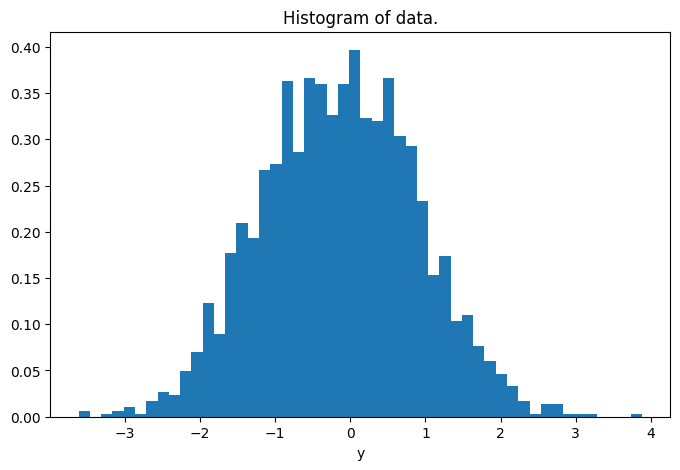

In [5]:
plt.figure(figsize=(8, 5))
plt.hist(np.array(y), bins=50, density=True)
plt.xlabel("y")
plt.title("Histogram of data.")
plt.show()

## Sampling

The Elliptical Slice sampler samples a latent parameter from the Gaussian prior, builds an ellipse passing though the previous position and the latent variable, and samples points from this ellipse which it then corrects for the likelihood using slice sampling. More details can be found in the [original paper](https://arxiv.org/abs/1001.0175) {cite:p}`ellipticalslicesampling2010`.

We compare the sampling time to NUTS, notice the difference in computation times. A couple of important considerations when using the elliptical slice sampler:
- The Elliptical slice sampler takes as input the likelihood function and the mean and covariance $\Sigma$ parameters of the Gaussian prior separetley, since **the sampler assumes that the prior is Gaussian**. On the contrary case of NUTS, the algorithm takes as input the unnormalized posterior distribution, i.e. the likelihood times the prior density.
- The Ellipical slice sampler is tuning-free, the warm up iterations are needed only for the sampler to start from a sensible initial position. While for NUTS the warm up samples are necessary not only to find a sensible initial position but also to tune the parameters of the algorithm, aiming at some average acceptance probability of its Metropolis-Hastings step. This additional tuning also contributes to the longer computation time.

In [6]:
# sampling parameters
n_warm = 2000
n_iter = 8000

In [7]:
%%time
loglikelihood_fn = lambda f: -0.5 * jnp.dot(y - f, y - f) / y_sd**2
init, kernel = elliptical_slice(loglikelihood_fn, mean=jnp.zeros(n), cov=Sigma)
states, info = inference_loop(jrnd.PRNGKey(0), init(f), kernel, n_warm + n_iter)
samples = states.position[n_warm:]

CPU times: user 8.49 s, sys: 333 ms, total: 8.82 s
Wall time: 8.66 s


In [8]:
%%time
n_iter = 2000

logdensity_fn = lambda f: loglikelihood_fn(f) - 0.5 * jnp.dot(f @ invSigma, f)
warmup = window_adaptation(nuts, logdensity_fn, n_warm, target_acceptance_rate=0.8)
key_warm, key_sample = jrnd.split(jrnd.PRNGKey(0))
(state, params), _ = warmup.run(key_warm, f)
kernel = nuts(logdensity_fn, **parameters).step
states, _ = inference_loop(key_sample, state, kernel, n_iter)

NameError: name 'parameters' is not defined

We check that the sampler is targeting the correct distribution by comparing the sample's mean and covariance to the conjugate results, and plotting the predictive distribution of our samples over the real observations.

In [9]:
error_mean = jnp.mean((samples.mean(axis=0) - posterior_mean) ** 2)
error_cov = jnp.mean((jnp.cov(samples, rowvar=False) - posterior_cov) ** 2)
print(
    f"Mean squared error for the mean vector {error_mean} and covariance matrix {error_cov}"
)

Mean squared error for the mean vector 0.00015894697571638972 and covariance matrix 1.6154511683907913e-07


In [10]:
keys = jrnd.split(rng, 1000)
predictive = jax.vmap(lambda k, f: f + jrnd.normal(k, (n,)) * y_sd)(
    keys, samples[-1000:]
)

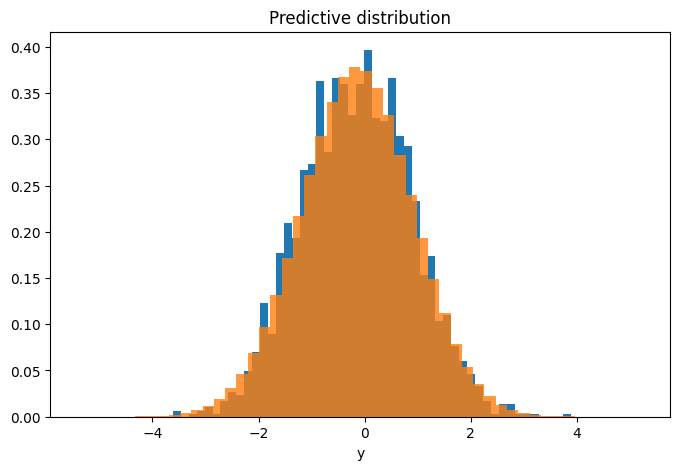

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(np.array(y), bins=50, density=True)
plt.hist(np.array(predictive.reshape(-1)), bins=50, density=True, alpha=0.8)
plt.xlabel("y")
plt.title("Predictive distribution")
plt.show()

## Diagnostics

The Elliptical slice sampler does not have a Metropolis-Hastings step, at every iteration it proposes a new position using slice sampling on the likelihood. The sampler is more efficient the less informative the likelihood is in comparison to the prior.

Assuming the degenerate case when the likelihood is always equal to 1 (infinite variance, not informative), we have that the slice sampler will always accept the first point it samples from the ellipsis, hence the number of sub iterations per iteration of the sampler will always be 1. To see this, notice that all the points on the ellipsis keep the joint distribution given by the *prior* measure for the target variable $\mathbf{f}$ and the same measure but for the latent variable, invariant. We can get an idea of how efficient the sampler is by looking at the number of sub iterations per iteration of the sampler, below we plot a histogram for our current example.

Another parameter of interest for diagnostics is the location on the ellipse the returned sample is from. This parameter, dubbed theta, is expressed in radians hence putting it on the interval $[-2\pi, 2\pi]$ (i.e. moving around the ellipse clockwise for positive numbers and counter clockwise for negative numbers). If theta $\in \{0, -2\pi, 2\pi\}$ we are at the initial position of the iteration, i.e. the closer theta is to any of these three values the closer the new sample is to the previous one. A histogram for this parameter is plotted below.

Since the likelihood's variance is set at 1., it is quite informative. Increasing the likelihood's variance leads to less sub iterations per iteration of the Elliptical Slice sampler and the parameter theta becoming more uniform on its range.

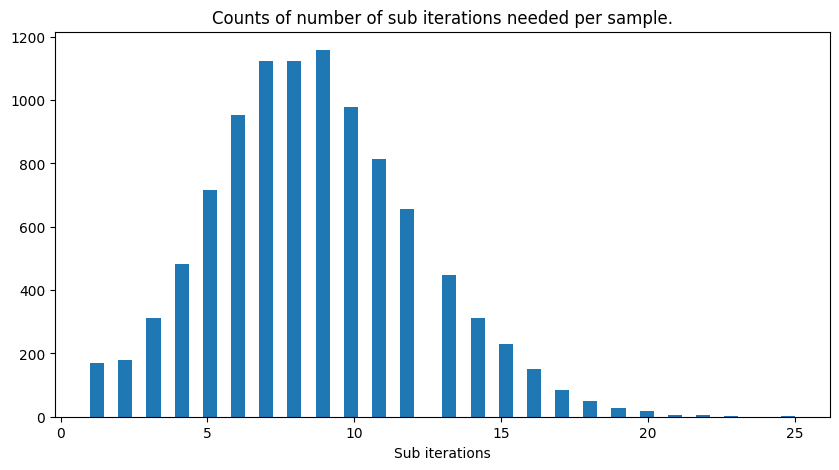

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(np.array(info.subiter), bins=50)
plt.xlabel("Sub iterations")
plt.title("Counts of number of sub iterations needed per sample.")
plt.show()

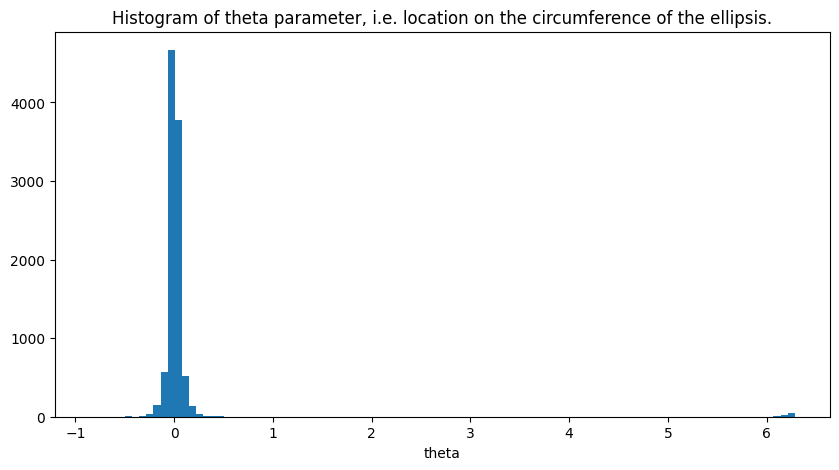

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(np.array(info.theta), bins=100)
plt.xlabel("theta")
plt.title(
    "Histogram of theta parameter, i.e. location on the circumference of the ellipsis."
)
plt.show()

```{bibliography}
:filter: docname in docnames
```